<a href="https://colab.research.google.com/github/dasamitansu159/Physic-Informed-Neural-Networks/blob/main/Schrodinger_Deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.6 MB/s eta 0:00:00


**Problem setup**  
  
We are going to solve the non-linear Schrödinger equation given by  
$i h_t + \frac{1}{2} h_{xx} + |h|^2h = 0$  
  
with periodic boundary conditions as  
$x \in [-5,5], \quad t \in [0, \pi/2]$  
$h(t, -5) = h(t,5)$  
$h_x(t, -5) = h_x(t,5)$  
  
and initial condition equal to  
$h(0,x) = 2 sech(x)$



Deepxde only uses real numbers, so we need to explicitly split the real and imaginary parts of the complex PDE.  
  
In place of the single residual  
$f = ih_t + \frac{1}{2} h_{xx} +|h|^2 h$  
  
we get the two (real valued) residuals  
$f_{\mathcal{R}} = u_t + \frac{1}{2} v_{xx} + (u^2 + v^2)v$  
$f_{\mathcal{I}} = v_t - \frac{1}{2} u_{xx} - (u^2 + v^2)u$  
  
where u(x,t) and v(x,t) denote respectively the real and the imaginary part of h.  


In [ ]:
import numpy as np

import deepxde as dde

# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.io

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [ ]:
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi / 2

# Creation of the 2D domain (for plotting and input)
x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [ ]:
# The "physics-informed" part of the loss


def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]

In [ ]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)

# Initial conditions
def init_cond_u(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])


def init_cond_v(x):
    return 0


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=10000,
    num_boundary=400,
    num_initial=400,
    train_distribution="pseudo",
)

# Network architecture
net = dde.nn.FNN([2] + [100] * 4 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)

Adam optimization.  

In [ ]:
# To employ a GPU accelerated system is highly encouraged.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=20000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.140894 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.785099 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [8.36e-03, 3.25e-03, 7.41e-02, 1.64e-04, 3.78e-02, 4.86e-04, 7.34e-01, 4.04e-03]    [8.36e-03, 3.25e-03, 7.41e-02, 1.64e-04, 3.78e-02, 4.86e-04, 7.34e-01, 4.04e-03]    []  
1000      [1.03e-02, 1.17e-02, 8.33e-06, 6.63e-05, 1.29e-06, 1.15e-05, 2.01e-02, 2.87e-03]    [1.03e-02, 1.17e-02, 8.33e-06, 6.63e-05, 1.29e-06, 1.15e-05, 2.01e-02, 2.87e-03]    []  
2000      [6.95e-03, 1.13e-02, 9.13e-06, 7.26e-05, 1.97e-05, 1.30e-05, 1.40e-02, 1.01e-03]    [6.95e-03, 1.13e-02, 9.13e-06, 7.26e-05, 1.97e-05, 1.30e-05, 1.40e-02, 1.01e-03]    []  
3000      [5.40e-03, 6.24e-03, 1.22e-06, 2.58e-05, 3.26e-06, 3.23e-05, 1.03e-02, 4.04e-04]    [5.40e-03, 6.24e-03, 1.22e-06, 2.58e-05, 3.26e-06, 3.23e-05, 1.03e-02, 4.04e-04]    []  
4000      [4.22e-03, 3.14e-03, 2

(<deepxde.model.LossHistory at 0x7b3fc62e3850>,
 <deepxde.model.TrainState at 0x7b3fc62e3610>)

L-BFGS optimization.

In [ ]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=20000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()

Compiling model...
'compile' took 0.563637 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
20000     [6.85e-04, 6.74e-04, 2.72e-06, 2.10e-06, 2.84e-05, 5.58e-07, 6.18e-05, 2.85e-05]    [6.85e-04, 6.74e-04, 2.72e-06, 2.10e-06, 2.84e-05, 5.58e-07, 6.18e-05, 2.85e-05]    []  
21000     [1.17e-05, 1.29e-05, 3.07e-08, 2.41e-07, 7.74e-08, 1.11e-07, 3.57e-06, 1.37e-07]    [1.17e-05, 1.29e-05, 3.07e-08, 2.41e-07, 7.74e-08, 1.11e-07, 3.57e-06, 1.37e-07]        
22000     [4.17e-06, 3.92e-06, 3.77e-08, 9.58e-08, 2.57e-08, 4.65e-08, 2.01e-06, 6.43e-08]    [4.17e-06, 3.92e-06, 3.77e-08, 9.58e-08, 2.57e-08, 4.65e-08, 2.01e-06, 6.43e-08]        
23000     [1.96e-06, 1.83e-06, 1.20e-08, 6.36e-08, 3.56e-08, 1.46e-08, 1.71e-06, 6.59e-08]    [1.96e-06, 1.83e-06, 1.20e-08, 6.36e-08, 3.56e-08, 1.46e-08, 1.71e-06, 6.59e-08]        
24000     [1.

(<deepxde.model.LossHistory at 0x7b3fc62e3850>,
 <deepxde.model.TrainState at 0x7b3fc62e3610>)

In [ ]:
# load the data
data = scipy.io.loadmat('NLS.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

In [ ]:
X_star = np.hstack((XX.flatten()[:, None], TT.flatten()[:, None]))

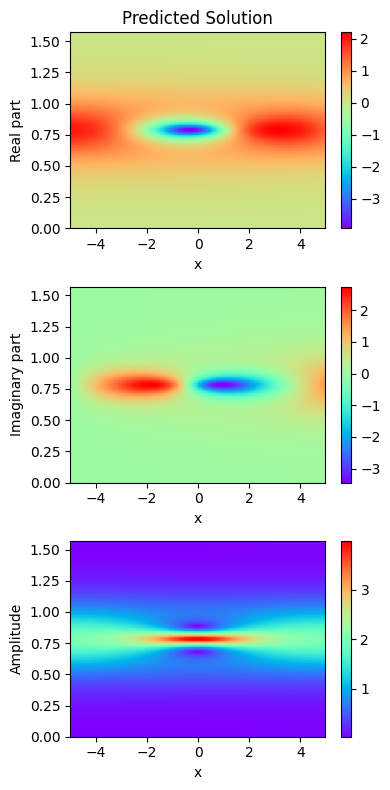

In [ ]:
# Make prediction
prediction = model.predict(X_star, operator=None)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

h = np.sqrt(u ** 2 + v ** 2)


# Plot predictions
fig, ax = plt.subplots(3, figsize=(4, 8))

im1 = ax[0].imshow(
    u.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=(np.min(XX), np.max(XX), np.min(t), np.max(TT)),
    origin="lower",
    aspect="auto",
)
fig.colorbar(im1, ax=ax[0])
ax[0].set_title("Predicted Solution")
ax[0].set_ylabel("Real part")
ax[0].set_xlabel("x")

im2 = ax[1].imshow(
    v.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=(np.min(XX), np.max(XX), np.min(t), np.max(TT)),
    origin="lower",
    aspect="auto",
)
fig.colorbar(im2, ax=ax[1])
ax[1].set_ylabel("Imaginary part")
ax[1].set_xlabel("x")

im3 = ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=(np.min(XX), np.max(XX), np.min(t), np.max(TT)),
    origin="lower",
    aspect="auto",
)
fig.colorbar(im3, ax=ax[2])
ax[2].set_ylabel("Amplitude")
ax[2].set_xlabel("x")

plt.tight_layout()
plt.show()

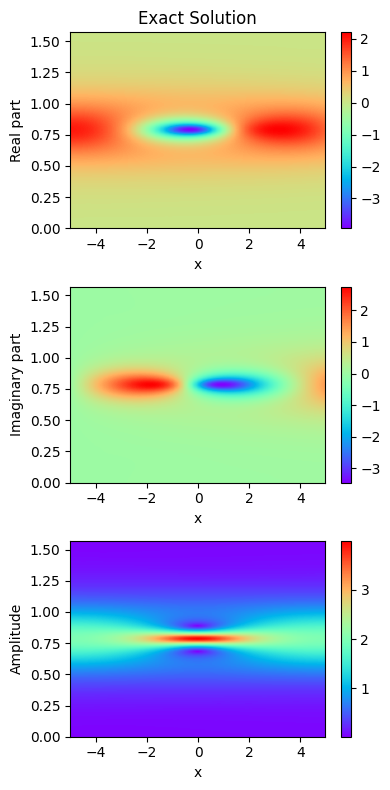

In [ ]:
Z_real = np.real(usol)
Z_imag = np.imag(usol)

h_exact = np.sqrt(Z_real ** 2 + Z_imag ** 2)

fig, ax = plt.subplots(3, figsize=(4, 8))

im1 = ax[0].imshow(Z_real, extent=(np.min(XX), np.max(XX), np.min(t), np.max(TT)), origin='lower',  aspect="auto", cmap='rainbow')
fig.colorbar(im1, ax=ax[0])
ax[0].set_title("Exact Solution")
ax[0].set_ylabel("Real part")
ax[0].set_xlabel("x")

im2 = ax[1].imshow(Z_imag, extent=(np.min(XX), np.max(XX), np.min(TT), np.max(TT)), origin='lower',aspect="auto", cmap='rainbow')
fig.colorbar(im2, ax=ax[1])
ax[1].set_ylabel("Imaginary part")
ax[1].set_xlabel("x")

im3 = ax[2].imshow(h_exact, extent=(np.min(XX), np.max(XX), np.min(t), np.max(TT)), origin='lower',aspect="auto", cmap='rainbow')
fig.colorbar(im3, ax=ax[2])
ax[2].set_ylabel("Amplitude")
ax[2].set_xlabel("x")

plt.tight_layout()
plt.show()


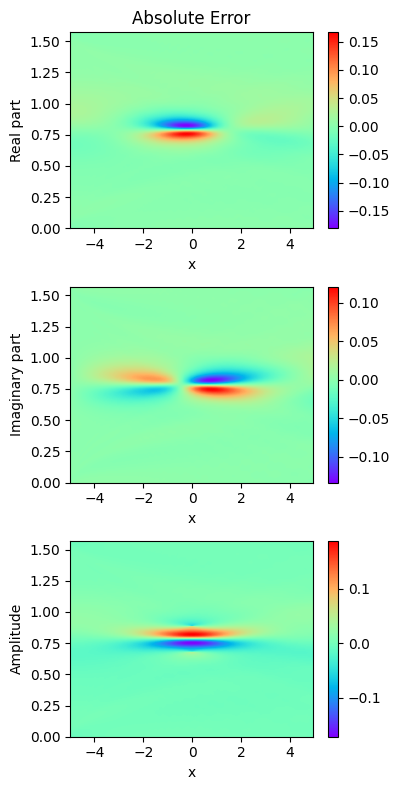

Absolute error in real part 0.0013701033756782438
Absolute error in imaginary part 0.0005763424697160797
Absolute error in amplitude 0.0021737536923084064


In [ ]:
Z_real = np.real(usol)
Z_imag = np.imag(usol)

h_exact = np.sqrt(Z_real ** 2 + Z_imag ** 2)

fig, ax = plt.subplots(3, figsize=(4, 8))

im1 = ax[0].imshow(Z_real - u.T, extent=(np.min(XX), np.max(XX), np.min(t), np.max(TT)), origin='lower', cmap='rainbow', aspect='auto')
fig.colorbar(im1, ax=ax[0])
ax[0].set_title("Absolute Error")
ax[0].set_ylabel("Real part")
ax[0].set_xlabel("x")

im2 = ax[1].imshow(Z_imag - v.T, extent=(np.min(XX), np.max(XX), np.min(TT), np.max(TT)), origin='lower', cmap='rainbow', aspect='auto')
fig.colorbar(im2, ax=ax[1])
ax[1].set_ylabel("Imaginary part")
ax[1].set_xlabel("x")

im3 = ax[2].imshow(h_exact - h.T, extent=(np.min(XX), np.max(XX), np.min(t), np.max(TT)), origin='lower', cmap='rainbow', aspect='auto')
fig.colorbar(im3, ax=ax[2])
ax[2].set_ylabel("Amplitude")
ax[2].set_xlabel("x")

plt.tight_layout()
plt.show()

print(f"Absolute error in real part {np.mean((Z_real - u.T)[:-1, :])}")
print(f"Absolute error in imaginary part {np.mean((Z_imag - v.T)[:-1, :])}")
print(f"Absolute error in amplitude {np.mean((h_exact - h.T)[:-1, :])}")

In [ ]:
Z_real.shape

(256, 201)

In [ ]:
u.T.shape

(256, 201)

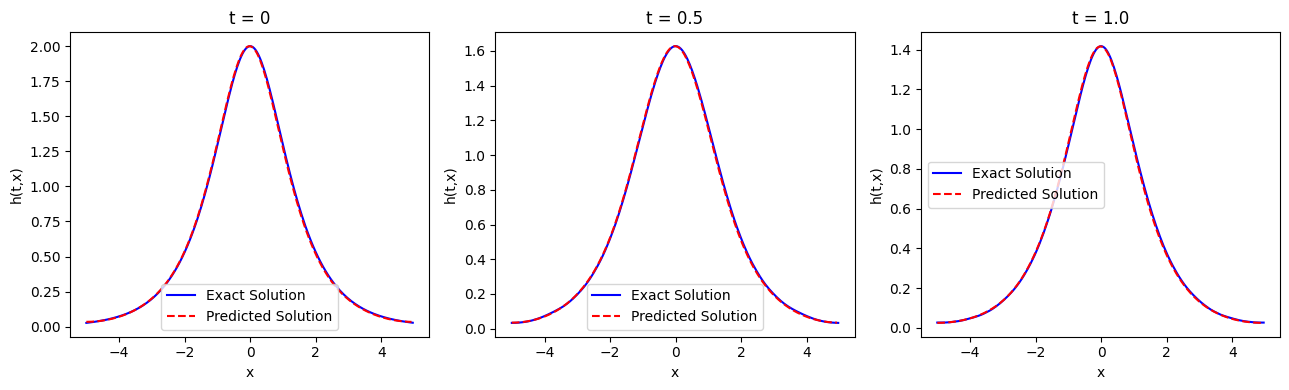

In [ ]:
fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.plot(x_star, Z_real[:, 0], color='blue', label='Exact Solution')
plt.plot(x_star, u.T[:, 0], '--', color='red', label='Predicted Solution')
plt.xlabel('x')
plt.ylabel('h(t,x)')
plt.title('t = 0')
plt.legend()
plt.tight_layout()

# Second subplot
plt.subplot(1, 3, 2)
plt.plot(x_star, Z_real[:, 25], color='blue', label='Exact Solution')
plt.plot(x_star, u.T[:, 25], '--', color='red', label='Predicted Solution')
plt.xlabel('x')
plt.ylabel('h(t,x)')
plt.title('t = 0.5')
plt.legend()
plt.tight_layout()

# Third subplot
plt.subplot(1, 3, 3)
plt.plot(x_star, Z_real[:, -1], color='blue', label='Exact Solution')
plt.plot(x_star, u.T[:, -1], '--', color='red', label='Predicted Solution')
plt.xlabel('x')
plt.ylabel('h(t,x)')
plt.title('t = 1.0')
plt.legend()
plt.tight_layout()
plt.savefig("2")
plt.show()